# Proyecto 2 — Optimización de carga de datos 
**Objetivo:** comparar **Pandas** vs **PyTorch DataLoader** para cargar `nlp_prueba_cc0c2_large.csv` (~10000 oraciones), midiendo **tiempo por epoch** y **RAM** en:
1) Pandas in-memory
2) Pandas eficientes (chunk)
3) DataLoader + Dataset
4) DataLoader + IterableDataset

Incluye: semillas y **shuffling estable**, `collate_fn` con **padding**, **pseudocódigo de prefetcher**, y **respuestas de teoría**.


In [23]:
# Importaciones y set de semillas

import os, sys, time, math, re, csv, random, hashlib
import psutil
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, IterableDataset
from torch.nn.utils.rnn import pad_sequence

def set_seeds(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    g = torch.Generator() # para que el shuffing del dataloader sea estable
    g.manual_seed(seed)
    return g

SEED = 42
GENERATOR = set_seeds(SEED)

print({
    "python": sys.version.split()[0],
    "pandas": pd.__version__,
    "torch": torch.__version__,
    "psutil": psutil.__version__,
})

{'python': '3.11.13', 'pandas': '2.3.2', 'torch': '2.8.0+cu128', 'psutil': '7.1.0'}


In [24]:
# Definir variables locales
CSV_PATH = "data/nlp_prueba_cc0c2_large.csv" 
COL_DATA = "Texto"
LABEL_COL = "Categoría"
BATCH_SIZE = 32

LABEL2ID = {"Negativo": 0, "Neutral": 1, "Positivo": 2} # conversion de categoria a enteros
ID2LABEL = {v: k for k, v in LABEL2ID.items()}

# Tokens especiales, aunque este proceso no es el que más se le debe prestar atención en este proyecto
PAD_TOKEN = "<pad>"
UNK_TOKEN = "<unk>"

In [25]:
# tokenizer simple y función para construir un vocabulario desde los registros en Texto
from collections import Counter

tokenizer_regex = re.compile(
   # palabras con acento, separados por '-' o "'" , números con '.' o ','
    r"[A-Za-zÁÉÍÓÚÜÑáéíóúüñ]+(?:[-'][A-Za-zÁÉÍÓÚÜÑáéíóúüñ]+)*|\d+(?:[.,]\d+)?"
)

def simple_tokenize(text: str):
    # devuelve la lista de tokens
    return tokenizer_regex.findall(str(text))

# Todo los registros en la RAM, todo de golpe
def build_vocab_from_texts(texts, min_freq: int = 1):
  cnt = Counter()
  for t in texts:
      cnt.update(simple_tokenize(t))
  # vocab incluye <pad> y <unk>
  vocab_list = [PAD_TOKEN, UNK_TOKEN] + [
      tok for tok, f in sorted(cnt.items(), key=lambda x: (-x[1], x[0])) if f >= min_freq # ordenar por frecuencia y alfabeticamente
  ]
  stoi = {tok: i for i, tok in enumerate(vocab_list)} # diccionario string to index
  itos = {i: tok for tok, i in stoi.items()} # diccionario index to string
  return stoi, itos

# Vocab sin usar todo el RAM de golpe
def build_vocab_streaming(csv_path, text_col, min_freq: int = 1):
  cnt = Counter()
  with open(csv_path, newline='', encoding='utf-8') as f:
      # lee el csv linea por linea, sin usar todo el ram de golpe
      reader = csv.DictReader(f)
      for row in reader:
          cnt.update(simple_tokenize(row[text_col]))
  vocab_list = [PAD_TOKEN, UNK_TOKEN] + [
      tok for tok, f in sorted(cnt.items(), key=lambda x: (-x[1], x[0])) if f >= min_freq
  ]
  stoi = {tok: i for i, tok in enumerate(vocab_list)}
  itos = {i: tok for tok, i in stoi.items()}
  return stoi, itos

def numericalize(tokens, stoi):
    # Convirte una lista de tokens en un array de numeros, el token <unk> es el indice 1
    unk_id = stoi.get(UNK_TOKEN, 1)
    return [stoi.get(tok, unk_id) for tok in tokens]



In [26]:
# Carga de CSV en pandas para el in-memory
csv_path = CSV_PATH
df = pd.read_csv(csv_path)

# verificar que sí existen las columnas correspondientes
assert {COL_DATA, LABEL_COL}.issubset(df.columns), f"El CSV debe tener columnas: {COL_DATA}, {LABEL_COL}"

# convertir en lista los registros de acada columna 
texts = df[COL_DATA].astype(str).tolist()
labels = df[LABEL_COL].map(LABEL2ID).astype(int).tolist() # lista de enteros 0, 1 o 2

# Usamos ambos vocab 
stoi, itos = build_vocab_streaming(csv_path, COL_DATA, min_freq=1)
PAD_ID = stoi[PAD_TOKEN]
UNK_ID = stoi[UNK_TOKEN]

print(f"Vocab size (streaming): {len(stoi)} | Clases: {len(LABEL2ID)} | Muestras: {len(texts)}")

stoi, itos = build_vocab_from_texts(texts, min_freq=1)
PAD_ID = stoi[PAD_TOKEN]
UNK_ID = stoi[UNK_TOKEN]

print(f"Vocab size (in-memory): {len(stoi)} | Clases: {len(LABEL2ID)} | Muestras: {len(texts)}")


Vocab size (streaming): 73 | Clases: 3 | Muestras: 10005
Vocab size (in-memory): 73 | Clases: 3 | Muestras: 10005


In [27]:
# Dataloader + Dataset con collate_fn

class CustomDataset(Dataset):
    def __init__(self, texts, labels, stoi):
        self.texts = texts # lista[str]
        self.labels = labels # lista[int]
        self.stoi = stoi # vocab : token -> id
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        toks = simple_tokenize(self.texts[idx]) # usa tokenizer simple
        ids = numericalize(toks, self.stoi) # tokens a ids
        x = torch.tensor(ids, dtype=torch.long) # secuenciliza valores enteros
        y = torch.tensor(self.labels[idx], dtype=torch.long) 
        return x, y

def collate_pad(batch):
    # formar batches con padding
    xs, ys = zip(*batch)
    lengths = torch.tensor([len(x) for x in xs], dtype=torch.long)
    padded = pad_sequence(xs, batch_first=True, padding_value=PAD_ID)
    ys = torch.stack(ys)
    return padded, lengths, ys

# Dataloader con shuffle estable y sin shuffle
ds = CustomDataset(texts, labels, stoi)

# usamos GENERATOR para el shuffle sería determinista 
dl_shuffle = DataLoader(
    ds, batch_size=BATCH_SIZE, shuffle=True, generator=GENERATOR,
    collate_fn=collate_pad, pin_memory=False
)

dl_no_shuffle = DataLoader(
    ds, batch_size=BATCH_SIZE, shuffle=False,
    collate_fn=collate_pad, pin_memory=False
)

# for xb, lengths, yb in dl_no_shuffle:
#    print(f"Tenemos esta tupla: {xb}, {lengths}, {yb}")
#    break

In [28]:
# IterableDataset

class CustomIterableDataset(IterableDataset):
  def __init__(self,csv_path,text_col,label_col,stoi,label2id,skip_header=True):
    self.csv_path = csv_path
    self.text_col = text_col
    self.label_col = label_col
    self.stoi = stoi
    self.label2id = label2id
    self.skip_header = skip_header

  def __iter__(self):
    worker_info = torch.utils.data.get_worker_info() # cuantos num_workers hay
    start = 0 # worker_id
    step = 1 # num_workers
    if worker_info is not None:
      start = worker_info.id
      step = worker_info.num_workers
    with open(self.csv_path, newline='', encoding='utf-8') as f:
      # leer csv
      reader = csv.reader(f)
      header = next(reader) if self.skip_header else None
      for i, row in enumerate(reader):
        if (i % step) != start:
          continue
        if header is None:
          text = row[0]; label_str = row[1]
        else:
          # obtiene los registrso de cada columna
          text = row[header.index(COL_DATA)]
          label_str = row[header.index(LABEL_COL)]
        # tokeniza cada texto y convierte a enteros cada token
        lab = self.label2id[label_str]
        ids = numericalize(simple_tokenize(text), self.stoi)
        # generador para convertir a tensores
        yield torch.tensor(ids, dtype=torch.long), torch.tensor(lab, dtype=torch.long)

ds_iter = CustomIterableDataset(csv_path, COL_DATA, LABEL_COL, stoi, LABEL2ID, skip_header=True)
# cargador de datos con prefetch , paralelismo; mejor no
dl_iter = DataLoader(ds_iter, batch_size=BATCH_SIZE, collate_fn=collate_pad,num_workers=0, pin_memory=False)

In [29]:
def ram_mb():
    # RAM actual del proceso en MB
    return psutil.Process(os.getpid()).memory_info().rss / (1024**2)

In [30]:
def run_pandas_full(csv_path, pad_id, batch_size=32):
    start_ram = ram_mb()
    peak_ram = start_ram
    t0 = time.perf_counter()

    # Leer CSV aquí (incluye el costo en RAM de pandas.read_csv)
    df = pd.read_csv(csv_path)
    peak_ram = max(peak_ram, ram_mb())
       
    all_ids = [torch.tensor(numericalize(simple_tokenize(t), stoi), dtype=torch.long)
               for t in df[COL_DATA].astype(str)]
    all_lbl = torch.tensor(df[LABEL_COL].map(LABEL2ID).astype(int).tolist())
    peak_ram = max(peak_ram, ram_mb())

    batches = 0
    for i in range(0, len(all_ids), batch_size):
        xs = all_ids[i:i+batch_size]
        ys = all_lbl[i:i+batch_size]
        _ = pad_sequence(xs, batch_first=True, padding_value=pad_id)
        _ = ys.sum().item()
        peak_ram = max(peak_ram, ram_mb())
        batches += 1

    elapsed = time.perf_counter() - t0
    end_ram = ram_mb()
    return {
        "time_s": elapsed,
        "start_ram_mb": start_ram,
        "end_ram_mb": end_ram,
        "delta_ram_mb": end_ram - start_ram,
        "peak_ram_mb": peak_ram,
        "batches": batches,
        "stable_shuffle": None
    }


def run_pandas_stream(csv_path, pad_id, chunksize=32):
    start_ram = ram_mb()
    peak_ram = start_ram
    t0 = time.perf_counter()

    batches = 0
    # antes del primer loop de chunks
    for chunk in pd.read_csv(csv_path, chunksize=chunksize):
        texts = chunk[COL_DATA].astype(str).tolist()
        labels = chunk[LABEL_COL].map(LABEL2ID).astype(int).tolist()
        xs = [torch.tensor(numericalize(simple_tokenize(t), stoi), dtype=torch.long) for t in texts]
        ys = torch.tensor(labels)
        _ = pad_sequence(xs, batch_first=True, padding_value=pad_id)
        _ = ys.sum().item()
        peak_ram = max(peak_ram, ram_mb())
        batches += 1

    elapsed = time.perf_counter() - t0
    end_ram = ram_mb()
    return {
        "time_s": elapsed,
        "start_ram_mb": start_ram,
        "end_ram_mb": end_ram,
        "delta_ram_mb": end_ram - start_ram,
        "peak_ram_mb": peak_ram,
        "batches": batches,
        "stable_shuffle": None
    }

def run_dataloader_map(csv_path, stoi, pad_id, batch_size=32, shuffle=True, seed=42):
    start_ram = ram_mb()
    peak_ram = start_ram
    t0 = time.perf_counter()

    # Leer CSV completo (incluye costo RAM de pandas.read_csv)
    df = pd.read_csv(csv_path)
    texts = df[COL_DATA].astype(str).tolist()
    labels = df[LABEL_COL].map(LABEL2ID).astype(int).tolist()

    # Construir Dataset y DataLoader
    ds = CustomDataset(texts, labels, stoi)
    generator = set_seeds(seed)
    dl = DataLoader(
        ds, batch_size=batch_size, shuffle=shuffle,
        generator=generator if shuffle else None,
        collate_fn=collate_pad,
        pin_memory=False
    )

    # Iterar batches
    batches = 0
    for xb, lengths, yb in dl:
        _ = (xb.sum() + yb.sum() + lengths.sum()).item()
        peak_ram = max(peak_ram, ram_mb())
        batches += 1

    # Métricas 
    elapsed = time.perf_counter() - t0
    end_ram = ram_mb()
    return {
        "time_s": elapsed,
        "start_ram_mb": start_ram,
        "end_ram_mb": end_ram,
        "delta_ram_mb": end_ram - start_ram,
        "peak_ram_mb": peak_ram,
        "batches": batches,
        "stable_shuffle": 1 if shuffle else None
    }


def run_dataloader_iterable(csv_path):

    ds_iter = CustomIterableDataset(csv_path, COL_DATA, LABEL_COL, stoi, LABEL2ID, skip_header=True)
    # cargador de datos con prefetch , paralelismo; mejor no
    dl = DataLoader(ds_iter, batch_size=BATCH_SIZE, collate_fn=collate_pad,num_workers=2,prefetch_factor=2, pin_memory=False)
    start_ram = ram_mb()
    peak_ram = start_ram
    t0 = time.perf_counter()

    batches = 0
    for xb, lengths, yb in dl:
        _ = (xb.sum() + yb.sum() + lengths.sum()).item()
        peak_ram = max(peak_ram, ram_mb())
        batches += 1

    elapsed = time.perf_counter() - t0
    end_ram = ram_mb()
    return {
        "time_s": elapsed,
        "start_ram_mb": start_ram,
        "end_ram_mb": end_ram,
        "delta_ram_mb": end_ram - start_ram,
        "peak_ram_mb": peak_ram,
        "batches": batches,
        "stable_shuffle": None
    }


In [32]:
results = {}

print("Pandas (in-memory)")
results["pandas_full"] = run_pandas_full(csv_path, PAD_ID, batch_size=BATCH_SIZE)

print("Pandas (streaming por chunks)")
results["pandas_stream"] = run_pandas_stream(csv_path, PAD_ID, chunksize=BATCH_SIZE)

print("DataLoader con pandas read_csv (shuffle=True)")
results["dl_map_shuffle"] = run_dataloader_map(
    csv_path, stoi, PAD_ID, batch_size=BATCH_SIZE, shuffle=True, seed=SEED
)

print("DataLoader con pandas read_csv (shuffle=False)")
results["dl_map_noshuf"] = run_dataloader_map(
    csv_path, stoi, PAD_ID, batch_size=BATCH_SIZE, shuffle=False, seed=SEED
)

print("DataLoader iterable streamming")
results["dl_iterable"] = run_dataloader_iterable(csv_path)

res_df = pd.DataFrame(results).T
res_df["time_per_1k_samples_s"] = res_df["time_s"] * (1000.0 / len(df))

cols = [
    "time_s", "time_per_1k_samples_s",
    "start_ram_mb", "end_ram_mb", "delta_ram_mb", "peak_ram_mb",
    "batches", "stable_shuffle"
]
res_df = res_df[cols]
res_df.round(3)


Pandas (in-memory)
Pandas (streaming por chunks)
DataLoader con pandas read_csv (shuffle=True)
DataLoader con pandas read_csv (shuffle=False)
DataLoader iterable streamming


,time_s,time_per_1k_samples_s,start_ram_mb,end_ram_mb,delta_ram_mb,peak_ram_mb,batches,stable_shuffle
pandas_full,1.326,0.133,406.855,406.492,-0.363,407.742,313.0,NaN
pandas_stream,0.779,0.078,406.492,406.504,0.012,406.504,313.0,NaN
dl_map_shuffle,0.502,0.050,406.504,405.590,-0.914,406.504,313.0,1.0
dl_map_noshuf,0.335,0.033,405.590,405.664,0.074,405.664,313.0,NaN
dl_iterable,2.411,0.241,405.664,405.789,0.125,405.789,314.0,NaN


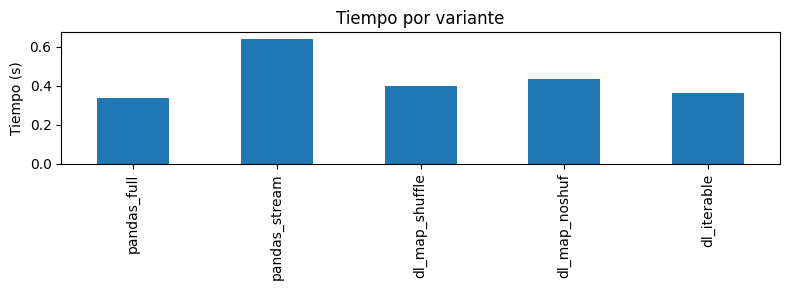

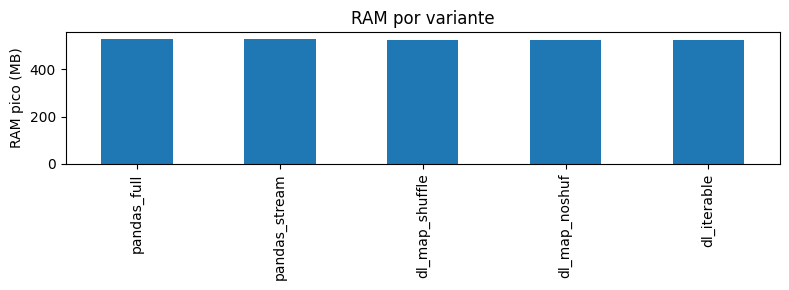

Guardado correctamente


In [ ]:
import matplotlib.pyplot as plt

os.makedirs("out", exist_ok=True)

# Tiempo por cada forma
plt.figure(figsize=(8,3))
res_df["time_s"].plot(kind="bar")
plt.ylabel("Tiempo (s)")
plt.title("Tiempo por variante")
plt.tight_layout()
plt.savefig("out/tiempo_por_forma_prep.png", dpi=150, bbox_inches="tight")
plt.show()

# RAM pico por cada forma
plt.figure(figsize=(8,3))
res_df["peak_ram_mb"].plot(kind="bar")
plt.ylabel("RAM pico (MB)")
plt.title("RAM por variante")
plt.tight_layout()
plt.savefig("out/ram_por_forma_prep.png", dpi=150, bbox_inches="tight")
plt.show()

print("Guardado correctamente")



## Teoría: iteradores, streaming, semillas, shuffling y prefetch

### Iteradores vs. listas en memoria
- **Listas in-memory**: materializan todo el dataset; acceso muy rápido por índice; RAM ↑ (puede romperse en datasets grandes).
- **Iteradores (streaming)**: generan ejemplos al vuelo; RAM casi constante; overhead de I/O y parsing por batch.


### Streaming vs. in-memory (pros/cons)
| Enfoque | Ventajas | Desventajas | Cuándo usar |
|---|---|---|---|
| **In-memory (Pandas full)** | Rápido al iterar, indexación eficiente | RAM proporcional al dataset | Dataset pequeño/mediano |
| **Streaming (chunks / IterableDataset)** | RAM estable, escala | Overhead I/O, parsing, shuffle no trivial(bufferizar) | Dataset grande o RAM limitada |


### Semillas y reproducibilidad
- Fijar `random`, `numpy`, `torch` + usar `torch.Generator` en DataLoader asegura **shuffling estable**.
- Reinstancia el `Generator` con misma semilla para repetir exactamente el orden de batches.

### Shuffling estable 
- Evita correlaciones por orden; mejora generalización; hace comparables los benchmarks.
- **Map-style**: `DataLoader(..., shuffle=True, generator=GENERATOR)`.
- **IterableDataset**: implementar **shuffle buffer** (ventana deslizante) si necesitas aleatoriedad sin cargar todo el dataset.

### Pseudocódigo de prefetch
El prefetch es tener workers que preparen los batch siguientes mientras que por ejemplo un modelo está usando o realizando cálculos con el actual.

```
func train_model(dataloader, modelo):
  queue = [] # prefetch buffer
  for batch in dataloader:
    if cola is empty:
      # first batch is send to train
      send batch to cpu
      train(model,batch)
    else:
      # use batch in memory 
      batch_to_use = queue.pop()
      # send batch to cpu
      train(model,batch_to_use)
  # while training, prepare next batch
  next_batch = getNextBatch()
  queue.append(next_batch)
  ```